In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.io as sio
import cv2
import matplotlib.image as mpimg
from matplotlib import path
from scipy.spatial.transform import Rotation 
from mpl_toolkits.mplot3d import Axes3D

In [3]:
DATA_DIR =  "data/data.mat"

data = sio.loadmat(DATA_DIR)['data']

In [4]:
x1 = data['x1'][0][0]; x2 = data['x2'][0][0]
x3 = data['x3'][0][0]; K = data['K'][0][0]
C = data['C'][0][0]; R = data['R'][0][0]
img1 = data['img1'][0][0].astype(np.uint8)
img2 = data['img2'][0][0].astype(np.uint8)
img3 = data['img3'][0][0].astype(np.uint8)

**Estimate Fundamental Matrix**

In [5]:
from estimate_fundamental_matrix import estimateFundamentalMatrix_RANSAC

#F, inliers1, inliers2 = estimateFundamentalMatrix_RANSAC(x1,x2, num_iter=4)
#my implementation is very very slow right now and does not give great solution
F, mask = cv2.findFundamentalMat(x1,x2,cv2.RANSAC)

In [6]:
#select only inlier points
inliers_left = x1[mask.ravel()==1].astype(int)
inliers_right = x2[mask.ravel()==1].astype(int)

**Visualisation of epipoles and epipolar lines**

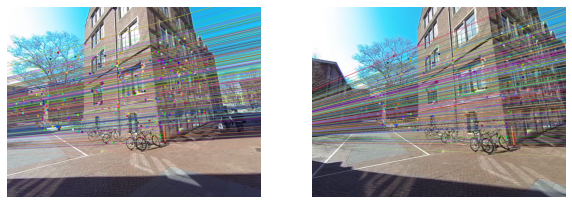

In [7]:
from helper import draw_epipolar_lines_using_FundamentalMatrix

draw_epipolar_lines_using_FundamentalMatrix(F, img1.copy(), img2.copy(), 
                                            inliers_left, inliers_right, 
                                            figSize=(10,5), color=True)

**Essential Matrix from Fundamental Matrix**

In [8]:
def EssentialMatrixFromFundamentalMatrix(K1,F,K2):
    '''
       :param K1 : instrinsics of the first camera
       :param K2 : intrinsic of the second camera
       :param F: fundamental matrix
       
       Key Step is to ensure that singularity of the Essential Matrix. Enforce the singular via the diagonal matrix
       
       Returns:
           E : Essential Matrix
    '''
    E = K2.T @ F @ K1
    U, _ ,VT = np.linalg.svd(E)
    S = np.diag(np.array([1, 1, 0]))
    
    E = U @ S  @ VT
    
    return E

In [9]:
E = EssentialMatrixFromFundamentalMatrix(K,F,K)

**Linear Triangulation**

In [10]:
from helper import vectorize_point

def LinearTriangulation(K, C1, R1, C2, R2, x1, x2):
    """                                                    
    Solves for the 3D recontructed for an  arbitrary scale 
    
    |x|   \   |X|
    | | = /\P | |    where P = KR[I | -RC]
    |1|       |1|
    
    For each point correspondence (x1,x2), it solves for 3D point by SVD using Ax = 0 such that ||x||=0

    :param x1:(np.array): size(n,2) image plane coordinates 
    :param x2:(np.array): size(n,2) image plane coordinates
    :param C1,R1,C2,R2: camera pose information
    :parma K: camera instrinsics
    
    Returns:
        X(np.array): size(n,3)
    """
    P1 = K@np.hstack((R1,-R1@C1))
    P2 = K@np.hstack((R2,-R2@C2))

    X = []
    
    for i in range(len(x1)):
        x = vectorize_point(x1[i])
        x_ = vectorize_point(x2[i])
        #SVD starts here
        A = np.vstack((np.cross(x,P1,axis=0), np.cross(x_,P2,axis=0)))
        #Solve for Ax = 0 and where x = (X,1) and hence enforce the last element to be 1
        U, S, V = np.linalg.svd(A)
        X_ = V.T[:,-1]
        #SVD ends here
        #enforce the homogenous constraints
        X_ = X_[:-1]/X_[-1]
        #append to the list of reconstructed 3D points
        X.append(X_)
        
    X = np.array(X)
    
    return X

In [11]:
R1 = np.diag([1,1,1])
C1 = np.array([0,0,0]).reshape(-1,1)
R2 = R
C2 = C

X = LinearTriangulation(K, C1, R1, C2, R2, x1, x2) #X has shape (N,4)

**Linear Camera Pose Estimation**

In [12]:
def vectorize_PnP(_2D_point,_3D_point):
    x,y = _2D_point
    X,Y,Z = _3D_point
    
    return [
        [X, Y, Z, 1, 0, 0, 0, 0, -x*X, -x*Y, -x*Z, -x],
        [0, 0, 0, 0, X, Y, Z, 1, -y*X, -y*Y, -y*Z, -y]
    ]


def solvelinearPnP(x,X,K):
    
    """
    To solve the projection equations, set up the equation using the corresposning 2D and 3D points.
    We have 2 equations, for each corresponding 2D and 3D points. To solve, we need atleast 6 point pairs
    
    It solves it using SVD by expressing the projection equation in the forms Ax = 0 such that ||x||=1
    where x is flattened P or x = P.flatten().T
    
    Note: This method calibrates the x values before the computation of P then extract R and t directly. 
          This means using instead of x, using the values xc = inv(K) x.

    :param x: (u,v) : (np.array) : size(Nx2) 
    :param X: (X,Y,Z): (np.array) : size(Nx3)
    :param K: (np.array) : camera instrinsics
    """
    
    #converts to (3,N) form with last row as 1s
    x = (np.hstack((x3, np.ones(x3.shape[0]).reshape(-1,1)))).T  
    #computes xc = inv(K) x
    x = np.linalg.inv(K)@x
    #converting to (Nx3) form
    x = x.T
    #dividing by it's element and converting into Nx2 shape. Last column is 1 always
    x = x[:, :-1]/x[:,-1].reshape(-1,1)  
    
    A=[]
    
    for p,q in zip(x,X):
        A.extend(vectorize_PnP(p,q))
        
    A = np.array(A)
    
    U,S,Vt = np.linalg.svd(A)
    P = Vt.T[:,-1].reshape(3,4)
    
    R_ = P[:,:3]
    
    U,S,Vt = np.linalg.svd(R_)
    
    if np.linalg.det(U@Vt)>0:
        R = U@Vt
        t = P[:,3]/S[0]
    elif(np.linalg.det(U@Vt)<0):
        R = -U@Vt
        t = -P[:,3]/S[0]
    
    C = -R.T@t
    
    return R,t.reshape(-1,1) ,C.reshape(-1,1)

In [13]:
R3,t3,C3  = solvelinearPnP(x3, X, K)

In [14]:
def calculateReprojectionPts(K,R,C,X):
    
    """
    :param K: instrinsic camera matrix
    :param R: rotation matrix
    :param C: displacement matrix
    :X: (np.array): size(N,3) :3D point coordinates
    (Note X must be multiple points or if is a single point is must be 2 dimensional vector
    of shape (1,2)
    
    Returns
        x: (np.array) : size (Nx2) non-homogeneous coordinates on the image plane
    """

    assert K.shape==(3,3)
    assert R.shape==(3,3)
    assert C.shape==(3,1)
    assert X.shape[1]==3
    
    if np.ndim(X)==1:
        X.reshape(1,-1)  
    
    #converting X into vector of form (X,1).T
    X = np.hstack((X,np.ones(X.shape[0]).reshape(-1,1))).T
    #calculating homogeneous projection coordinates
    x = K@np.hstack((R,-R@C1))@X
    #calculating non-homogeneous proection coordinates
    x = x[:-1,:]/x[-1,:]
    x = x.T
    return x

In [15]:
R1 = np.diag([1,1,1])
C1 = np.array([0,0,0]).reshape(-1,1)
R2 = R
C2 = C 

In [16]:
x1_proj = calculateReprojectionPts(K, R1, C1, X)
x2_proj = calculateReprojectionPts(K, R2, C2, X)
x3_proj = calculateReprojectionPts(K, R3, C3, X)

In [17]:
# Copied from https://github.com/zcemycl/Robotics/blob/master/Perception/Point%20Cloud/PointCloud.ipynb

def DisplayCorrespondence(img,x,xp):
    plt.imshow(img)
    err = 0
    for i in range(x.shape[0]):
        plt.plot([xp[i,0],x[i,0]],[xp[i,1],x[i,1]],'r-')
        plt.plot(x[i,0],x[i,1],'bo')

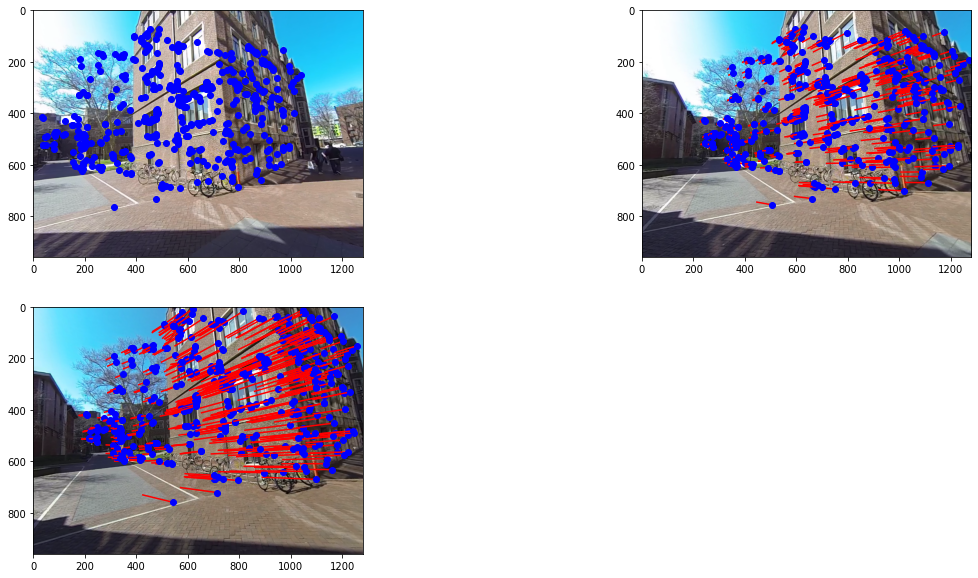

In [18]:
plt.figure(figsize = (20,10))
plt.subplot(2,2,1)
DisplayCorrespondence(img1,x1,x1_proj)
plt.subplot(2,2,2)
DisplayCorrespondence(img2,x2,x2_proj)
plt.subplot(2,2,3)
DisplayCorrespondence(img3,x3,x3_proj)

**Non-Linear Triangulation**

In [19]:
def Jacobian(K,C,R,X):
    """
    :param K:intrinsic
    :param C, R - poses of camera configuration
    :param X: 3D triangulated point
    
    """
    assert X.shape==(3,1)
    
    f = K[0][0]
    px = K[0][2]
    py = K[1][2]    
    
    x_proj = K@R@(X-C)
    u, v, w = x_proj.flatten()
    
    du_by_dX=np.array([f*R[0,0]+px*R[2,0], f*R[0,1]+px*R[2,1], f*R[0,2]+px*R[2,2]])
    dv_by_dX=np.array([f*R[1,0]+py*R[2,0], f*R[1,1]+py*R[2,1], f*R[1,2]+py*R[2,2]])
    dw_by_dX=R[2,:]
    
    J = np.array([[w*du_by_dX - u*dw_by_dX], [w*dv_by_dX-v*dw_by_dX]])/w**2
    
    return J.squeeze(1)

In [20]:
def SinglePointNonlinearTriangulation(K, C1, R1, C2, R2, C3, R3, x1, x2, x3, X):
    
    """
    :param K:intrinsic
    :param Ci, Ri - poses of camera{i}
    :param x1,x2,x3
    :param X: Single 3D triangulated point of shape (1,3), (3,) or (,3)
    
    Returns:
     delta_X
    """
    
    if np.ndim(X)==1 and (3 in X.shape):
        X=X.reshape(3,1)
    
    J1 = Jacobian(K,C1,R1,X)
    J2 = Jacobian(K,C2,R2,X)
    J3 = Jacobian(K,C3,R3,X)
    
    J = np.vstack((J1,J2,J2))
    
    x1_proj = K@R1@(X-C1); u1, v1, w1 = x1_proj.flatten()
    x2_proj = K@R2@(X-C2); u2, v2, w2 = x2_proj.flatten()
    x3_proj = K@R3@(X-C3); u3, v3, w3 = x3_proj.flatten()
    
    b = np.hstack((x1,x2,x3)).reshape(6,-1)
    fx = np.array([u1/w1, v1/w1, u2/w2, v2/w2, u3/w3, v3/w3]).reshape(6,-1)
    
    delta_X = (np.linalg.inv(J.T@J))@J.T@(b-fx) 
    X = X + delta_X
    
    return X

In [21]:
X_o = X.copy()

In [22]:
for j in range(10):
    X_new=[]
    for i in range(len(X)):
        X_=SinglePointNonlinearTriangulation(K, C1, R1, C2, R2, C3, R3, x1[i], x2[i], x3[i], X[i])
        X_new.append(X_.flatten())
    X=np.array(X_new)
    print("Iteration {} : Completed ".format(j+1))

Iteration 1 : Completed 
Iteration 2 : Completed 
Iteration 3 : Completed 
Iteration 4 : Completed 
Iteration 5 : Completed 
Iteration 6 : Completed 
Iteration 7 : Completed 
Iteration 8 : Completed 
Iteration 9 : Completed 
Iteration 10 : Completed 


In [24]:
x1_proj_new = calculateReprojectionPts(K, R1, C1, X)
x2_proj_new = calculateReprojectionPts(K, R2, C2, X)
x3_proj_new = calculateReprojectionPts(K, R3, C3, X)